In [1]:
file_cutoff = 55
plot_cutoff = 5.5
exclusion = 3

In [2]:
from numpy.core.fromnumeric import amin
import pandas as pd
from read_input import read_pdbs
import itertools
from itertools import product, combinations


native_pdb, fibril_pdb = read_pdbs()

# Make a dictionary from the pdb of resnum:resid from the pdb structure
pdb_resids = native_pdb.residues.resids.tolist()
amino_dict = dict(zip(pdb_resids,(list(native_pdb.residues.resnames))))

# Same dictionary but also with number and names
pdb_resid_name = native_pdb.residues.resnames + '_' + native_pdb.residues.resids.astype(str)
amino_dict_num = dict(zip(pdb_resids,pdb_resid_name))
#print(amino_dict)
#print(amino_dict_num)

# Create the DataFrame of the pairs list
pairs_list = pd.read_csv(f'GRETA/output_TTR/pairs_list_c{file_cutoff}_ex{exclusion}.txt', sep='\\s+')

pairs_list.insert(1, 'ai_resnumber', '')
pairs_list.insert(1, 'ai_resname', '')
pairs_list.insert(4, 'aj_resnumber', '')
pairs_list.insert(4, 'aj_resname', '')

# Separation of the atomtype and the aminoacid number. 
# The atomtype column will be replaced avoiding to create a column and delete this one.
pairs_list[['ai_resname', 'ai_resnumber']] = pairs_list.ai.str.split("_", expand = True)
pairs_list[['aj_resname', 'aj_resnumber']] = pairs_list.aj.str.split("_", expand = True)
# Replacing the atomtype values with aminoacid number as int
pairs_list['ai_resname'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resname'] = pairs_list['aj_resnumber'].astype(int)
# Conversion from str to int
pairs_list['ai_resnumber'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resnumber'] = pairs_list['aj_resnumber'].astype(int)
# Replacing the aminoacid number with the aminoacid name
pairs_list['ai_resname'] = pairs_list.ai_resname.map(amino_dict)
pairs_list['aj_resname'] = pairs_list.aj_resname.map(amino_dict)

print(pairs_list)#.to_string())


        ai ai_resname  ai_resnumber     aj aj_resname  aj_resnumber  type  \
0     CA_1        TYR             1   CA_1        TYR             1     1   
1     CA_1        TYR             1   CA_2        THR             2     1   
2     CA_1        TYR             1   CB_1        TYR             1     1   
3     CA_1        TYR             1  CB_11        SER            11     1   
4     CA_1        TYR             1   CB_2        THR             2     1   
...    ...        ...           ...    ...        ...           ...   ...   
1117   O_7        LEU             7    O_7        LEU             7     1   
1118   O_7        LEU             7    O_8        SER             8     1   
1119   O_8        SER             8    O_8        SER             8     1   
1120   O_8        SER             8    O_9        PRO             9     1   
1121   O_9        PRO             9    O_9        PRO             9     1   

            c6           c12     sigma  epsilon  
0     0.007164  3.719267e

In [3]:
contacts_histogram = {}
sigma_histogram = {}
for an in pdb_resids:
    # pdb_resids is the aminocid numbers
    # Selection of the rows contaning the aminoacid number of interest.
    # Note the | and not the &
    is_an = (pairs_list['ai_resnumber'] == an) | (pairs_list['aj_resnumber'] == an)

    # Filtering a dataframe containing only the aminoacid selected.
    pairs_an = pairs_list[is_an]

    print(f'Total amount of contacts made by {amino_dict_num.get(an)}:', len(pairs_an))
    pairs_an.loc[pairs_an['ai_resnumber'] == an, 'an_with_who'] = pairs_an['aj_resname'] + '_' + pairs_an['aj_resnumber'].astype(str)
    pairs_an.loc[pairs_an['ai_resnumber'] != an, 'an_with_who'] = pairs_an['ai_resname'] + '_' + pairs_an['ai_resnumber'].astype(str)
    #print(pairs_an.to_string())
    
    # Create Pandas Series with contact counts for every aminoacid in an selection:
    # an_with_who count of the unique values in column "an_with_who" in pairs_an dataframe
    an_with_who = pairs_an.an_with_who.value_counts()
    print(f'\nList of contacts based on aminoacid:\n{an_with_who.to_string()}')

    # Change "an_with_who" in a dictionary to put in a matrix
    contacts_histogram['{0}'.format(an)] = an_with_who.to_dict()
    print(f'\nAnd the consequent nested dictionary:\n{contacts_histogram}\n')


    # Matrix Sigma creation
    set_an_with_who = set(pairs_an["an_with_who"])

    sigma_dict = {}
    for s in set_an_with_who:
        sigma_dict[s] = 0.00000
        is_s = pairs_an["an_with_who"] == s
        sigmas_an = pairs_an[is_s]
        mean_sigma = sigmas_an['sigma'].mean()
        print(f'Average sigma of {amino_dict_num.get(an)} with {s}', '%.5f'%mean_sigma)
        sigma_dict[s] = '%.5f'%mean_sigma

    sigma_histogram['{0}'.format(an)] = sigma_dict
    #print(f'Nested dictionary of the sigmas:\n{sigma_histogram}\n\n')


#print(f'Complete matrix of all contacts:\n{contacts_histogram}\n')
#print(f'Complete matrix of the sigma distances:{sigma_histogram}')


Total amount of contacts made by TYR_1: 227

List of contacts based on aminoacid:
SER_11    66
TYR_1     64
TYR_10    50
THR_2     35
ILE_3     12

And the consequent nested dictionary:
{'1': {'SER_11': 66, 'TYR_1': 64, 'TYR_10': 50, 'THR_2': 35, 'ILE_3': 12}}

Average sigma of TYR_1 with SER_11 0.37266
Average sigma of TYR_1 with ILE_3 0.44903
Average sigma of TYR_1 with TYR_1 0.39620
Average sigma of TYR_1 with TYR_10 0.40948
Average sigma of TYR_1 with THR_2 0.38044
Total amount of contacts made by THR_2: 170

List of contacts based on aminoacid:
TYR_1     35
ILE_3     35
THR_2     26
TYR_10    26
PRO_9     20
SER_11    18
ALA_4     10

And the consequent nested dictionary:
{'1': {'SER_11': 66, 'TYR_1': 64, 'TYR_10': 50, 'THR_2': 35, 'ILE_3': 12}, '2': {'TYR_1': 35, 'ILE_3': 35, 'THR_2': 26, 'TYR_10': 26, 'PRO_9': 20, 'SER_11': 18, 'ALA_4': 10}}

Average sigma of THR_2 with SER_11 0.40904
Average sigma of THR_2 with ILE_3 0.38538
Average sigma of THR_2 with ALA_4 0.43862
Average sig

In [4]:
# Contact dataframe preparation

histo_df = pd.DataFrame(contacts_histogram)
histo_df[''] = histo_df.index.astype(str)
histo_df[''] = histo_df[''].str.split('_').str[1].astype(int)
histo_df.sort_values(by = [''], inplace = True)
histo_df.drop(columns='', inplace=True)
histo_df = histo_df.fillna(0)
histo_df.columns = list(amino_dict_num.values())
print(histo_df.to_string())



        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    64.0   35.0   12.0    0.0    0.0    0.0    0.0    0.0    0.0    50.0    66.0
THR_2    35.0   26.0   35.0   10.0    0.0    0.0    0.0    0.0   20.0    26.0    18.0
ILE_3    12.0   35.0   32.0   28.0    5.0    1.0    0.0   13.0   11.0    20.0     0.0
ALA_4     0.0   10.0   28.0   15.0   21.0    2.0   17.0    1.0   11.0     0.0     0.0
ALA_5     0.0    0.0    5.0   21.0   15.0   35.0   19.0    0.0    0.0     0.0     0.0
LEU_6     0.0    0.0    1.0    2.0   35.0   35.0   51.0    9.0    0.0     0.0     4.0
LEU_7     0.0    0.0    0.0   17.0   19.0   51.0   32.0   28.0   15.0     0.0     9.0
SER_8     0.0    0.0   13.0    1.0    0.0    9.0   28.0   21.0   36.0    29.0    35.0
PRO_9     0.0   20.0   11.0   11.0    0.0    0.0   15.0   36.0   28.0    48.0    11.0
TYR_10   50.0   26.0   20.0    0.0    0.0    0.0    0.0   29.0   48.0    63.0    33.0
SER_11   66.0   18.0    0.0    0.0    0.0    4.0    9.

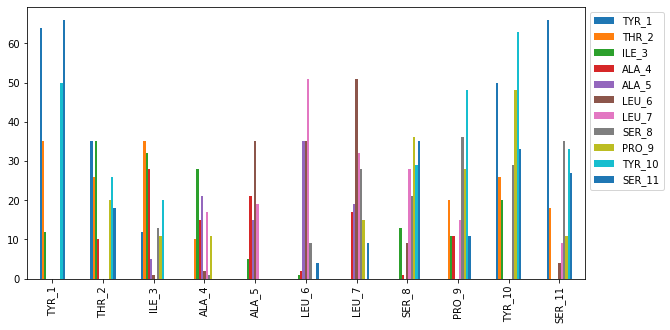

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_df.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.show()

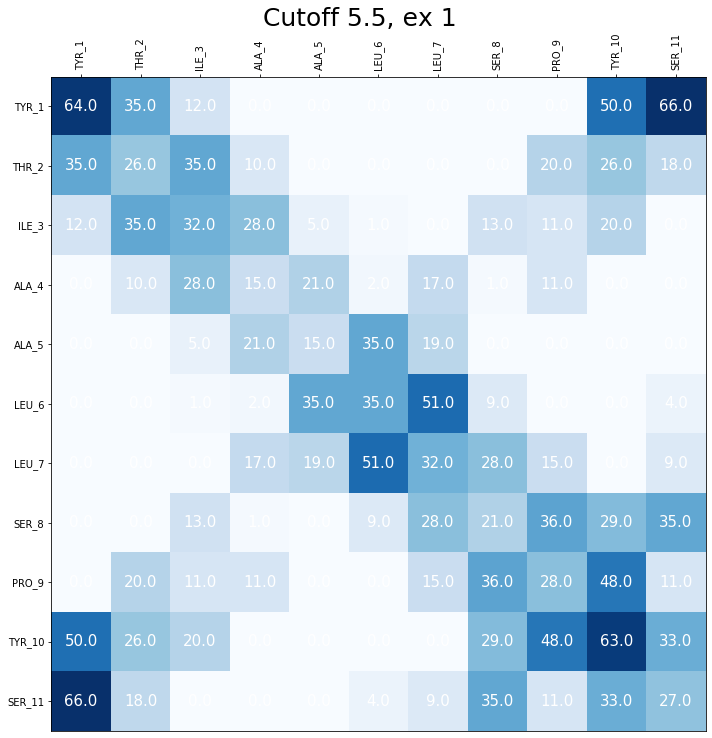

In [6]:
import numpy as np

matrix_df = histo_df.to_numpy()
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df.columns)))
ax.set_yticks(np.arange(len(histo_df.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df.columns))
ax.set_yticklabels(list(histo_df.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df.index)):
    for j in range(len(histo_df.columns)):
        text = ax.text(j,i, matrix_df[i,j], ha='center', va='center', color='w', fontsize = 15)
plt.suptitle(f'Cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
fig.tight_layout()

In [7]:
# Making a normalized dataframe and matrix
histo_df_norm = histo_df.div(histo_df.max().max())
pd.options.display.float_format = '{:.2f}'.format
print(histo_df_norm.to_string())

        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    0.97   0.53   0.18   0.00   0.00   0.00   0.00   0.00   0.00    0.76    1.00
THR_2    0.53   0.39   0.53   0.15   0.00   0.00   0.00   0.00   0.30    0.39    0.27
ILE_3    0.18   0.53   0.48   0.42   0.08   0.02   0.00   0.20   0.17    0.30    0.00
ALA_4    0.00   0.15   0.42   0.23   0.32   0.03   0.26   0.02   0.17    0.00    0.00
ALA_5    0.00   0.00   0.08   0.32   0.23   0.53   0.29   0.00   0.00    0.00    0.00
LEU_6    0.00   0.00   0.02   0.03   0.53   0.53   0.77   0.14   0.00    0.00    0.06
LEU_7    0.00   0.00   0.00   0.26   0.29   0.77   0.48   0.42   0.23    0.00    0.14
SER_8    0.00   0.00   0.20   0.02   0.00   0.14   0.42   0.32   0.55    0.44    0.53
PRO_9    0.00   0.30   0.17   0.17   0.00   0.00   0.23   0.55   0.42    0.73    0.17
TYR_10   0.76   0.39   0.30   0.00   0.00   0.00   0.00   0.44   0.73    0.95    0.50
SER_11   1.00   0.27   0.00   0.00   0.00   0.06   0.1

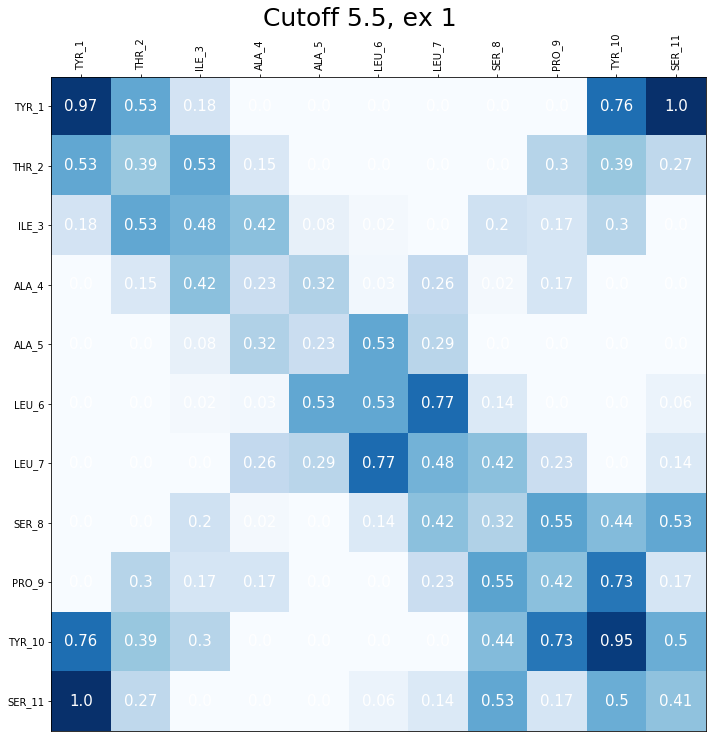

In [8]:
matrix_norm_df = histo_df_norm.to_numpy()
matrix_norm_df = matrix_norm_df.round(decimals = 2)

# plot creation
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_norm_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df_norm.columns)))
ax.set_yticks(np.arange(len(histo_df_norm.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df_norm.columns))
ax.set_yticklabels(list(histo_df_norm.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df_norm.index)):
    for j in range(len(histo_df_norm.columns)):
        text = ax.text(j,i, matrix_norm_df[i,j], ha='center', va='center', color='w', fontsize = 15)
plt.suptitle(f'Cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
fig.tight_layout()

In [9]:
# Sigmas dataframe preparation

pd.options.display.float_format = '{:,.5f}'.format
histo_sigma = pd.DataFrame(sigma_histogram)
histo_sigma = histo_sigma.apply(pd.to_numeric)
histo_sigma[''] = histo_sigma.index.astype(str)
histo_sigma[''] = histo_sigma[''].str.split('_').str[1].astype(int)
histo_sigma.sort_values(by = [''], inplace = True)
histo_sigma.drop(columns='', inplace=True)
#histo_sigma = histo_sigma.fillna(0)
histo_sigma.columns = list(amino_dict_num.values())
print(histo_sigma.to_string())


         TYR_1   THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8   PRO_9  TYR_10  SER_11
TYR_1  0.39620 0.38044 0.44903     nan     nan     nan     nan     nan     nan 0.40948 0.37266
THR_2  0.38044 0.40163 0.38538 0.43862     nan     nan     nan     nan 0.41496 0.38818 0.40904
ILE_3  0.44903 0.38538 0.41624 0.37314 0.42499 0.45621     nan 0.39143 0.40439 0.38870     nan
ALA_4      nan 0.43862 0.37314 0.38578 0.38829 0.40599 0.42061 0.46416 0.40331     nan     nan
ALA_5      nan     nan 0.42499 0.38829 0.38525 0.39275 0.42530     nan     nan     nan     nan
LEU_6      nan     nan 0.45621 0.40599 0.39275 0.39512 0.38273 0.42643     nan     nan 0.40789
LEU_7      nan     nan     nan 0.42061 0.42530 0.38273 0.39084 0.38939 0.41491     nan 0.43796
SER_8      nan     nan 0.39143 0.46416     nan 0.42643 0.38939 0.40247 0.37952 0.40501 0.39778
PRO_9      nan 0.41496 0.40439 0.40331     nan     nan 0.41491 0.37952 0.39592 0.39784 0.42767
TYR_10 0.40948 0.38818 0.38870     nan     nan    

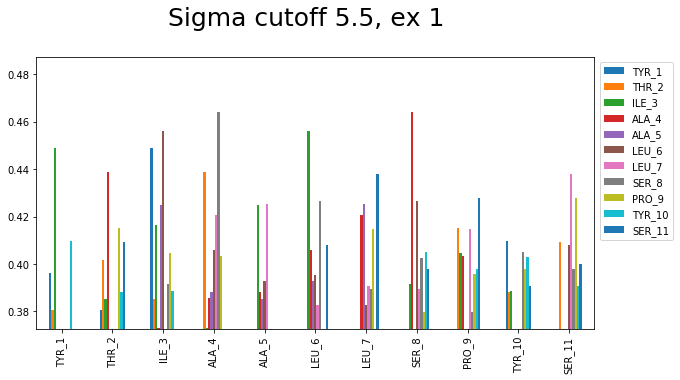

0.37266


In [10]:
histo_sigma.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.ylim(bottom=(histo_sigma.min()).min())
plt.suptitle(f'Sigma cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
plt.show()
print((histo_sigma.min()).min())

In [11]:
# Distance dataframe preparation

histo_distance = histo_sigma.apply(lambda a: a*(2**(1/6)))
histo_distance[''] = histo_distance.index.astype(str)
histo_distance[''] = histo_distance[''].str.split('_').str[1].astype(int)
histo_distance.sort_values(by = [''], inplace = True)
histo_distance.drop(columns='', inplace=True)
#histo_distance = histo_distance.fillna(0)
histo_distance.columns = list(amino_dict_num.values())
print(histo_distance.to_string())

         TYR_1   THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8   PRO_9  TYR_10  SER_11
TYR_1  0.44472 0.42703 0.50402     nan     nan     nan     nan     nan     nan 0.45963 0.41830
THR_2  0.42703 0.45081 0.43257 0.49233     nan     nan     nan     nan 0.46578 0.43572 0.45913
ILE_3  0.50402 0.43257 0.46721 0.41884 0.47704 0.51208     nan 0.43937 0.45391 0.43630     nan
ALA_4      nan 0.49233 0.41884 0.43302 0.43584 0.45571 0.47212 0.52100 0.45270     nan     nan
ALA_5      nan     nan 0.47704 0.43584 0.43243 0.44085 0.47738     nan     nan     nan     nan
LEU_6      nan     nan 0.51208 0.45571 0.44085 0.44351 0.42960 0.47865     nan     nan 0.45784
LEU_7      nan     nan     nan 0.47212 0.47738 0.42960 0.43870 0.43708 0.46572     nan 0.49159
SER_8      nan     nan 0.43937 0.52100     nan 0.47865 0.43708 0.45176 0.42600 0.45461 0.44649
PRO_9      nan 0.46578 0.45391 0.45270     nan     nan 0.46572 0.42600 0.44441 0.44656 0.48004
TYR_10 0.45963 0.43572 0.43630     nan     nan    

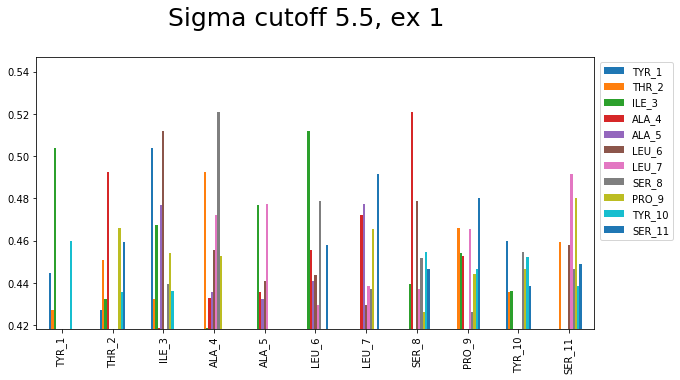

0.41829670692297094


In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_distance.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.ylim(bottom=(histo_distance.min()).min())
plt.suptitle(f'Sigma cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
plt.show()
print((histo_distance.min()).min())